In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import warnings
import scipy.stats as stats

# Modeling
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# --- CONFIGURATION ---
RAW_DIR = "raw_data"
ANNOT_DIR = "annotations"
SR = 16000

# Raw Data Loading

In [2]:
def load_raw_dataset(raw_dir, annot_dir, sr=16000):
    raw_segments = []
    metadata = []
    
    wav_files = glob.glob(os.path.join(raw_dir, "*.wav"))
    print(f"Scanning {len(wav_files)} files...")

    for wav_path in wav_files:
        base_name = os.path.splitext(os.path.basename(wav_path))[0]
        csv_path = os.path.join(annot_dir, base_name + ".csv")
        
        if not os.path.exists(csv_path): continue
        
        try:
            # Load full audio
            y_full, _ = librosa.load(wav_path, sr=sr)
            
            # Load CSV
            df = pd.read_csv(csv_path, header=None, names=['start', 'end', 'label'])
            
            for i, row in df.iterrows():
                start_sample = int(row['start'] * sr)
                end_sample = int(row['end'] * sr)
                
                # Bounds check
                if end_sample > len(y_full): end_sample = len(y_full)
                if start_sample >= end_sample: continue 
                
                # Extract
                segment = y_full[start_sample:end_sample]
                
                # Store
                raw_segments.append(segment)
                metadata.append({
                    'subject_id': base_name.split('_')[0],
                    'label': str(row['label']).strip().lower(),
                    'duration': len(segment)/sr,
                    'file_source': base_name
                })
                
        except Exception as e:
            print(f"Error processing {base_name}: {e}")
            
    return raw_segments, pd.DataFrame(metadata)

# Execute
X_raw_audio, df_meta = load_raw_dataset(RAW_DIR, ANNOT_DIR, SR)
print(f"Successfully loaded {len(X_raw_audio)} segments.")

Scanning 24 files...
Successfully loaded 422 segments.


# Raw Data Analysis

--- DATASET SUMMARY ---
Total Samples: 422
Total Duration: 406.95 seconds

--- CLASS DISTRIBUTION ---
label
fatigue    193
normal     129
cough      100
Name: count, dtype: int64

--- SUBJECT DISTRIBUTION ---
subject_id
sneha      80
olena      59
peyman     58
emre       57
yernur     49
narmeen    41
paula      41
sofia      37
Name: count, dtype: int64


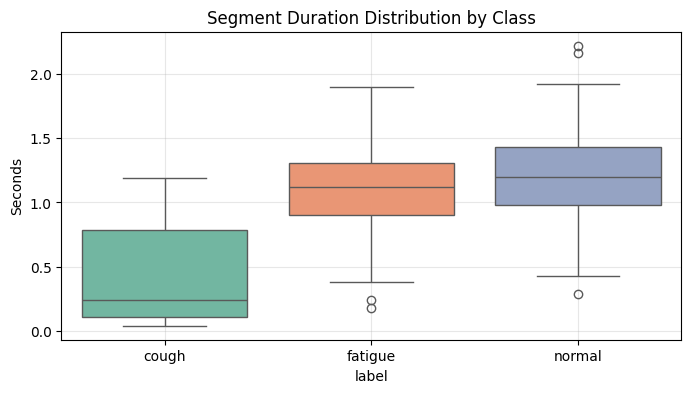

In [3]:
# --- RAW DATA ANALYSIS ---
print("--- DATASET SUMMARY ---")
print(f"Total Samples: {len(df_meta)}")
print(f"Total Duration: {df_meta['duration'].sum():.2f} seconds")

print("\n--- CLASS DISTRIBUTION ---")
print(df_meta['label'].value_counts())

print("\n--- SUBJECT DISTRIBUTION ---")
print(df_meta['subject_id'].value_counts())

# Visualization: Duration Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x='label', y='duration', data=df_meta, palette='Set2')
plt.title('Segment Duration Distribution by Class')
plt.ylabel('Seconds')
plt.grid(True, alpha=0.3)
plt.show()

# Sample Data Spectrogram

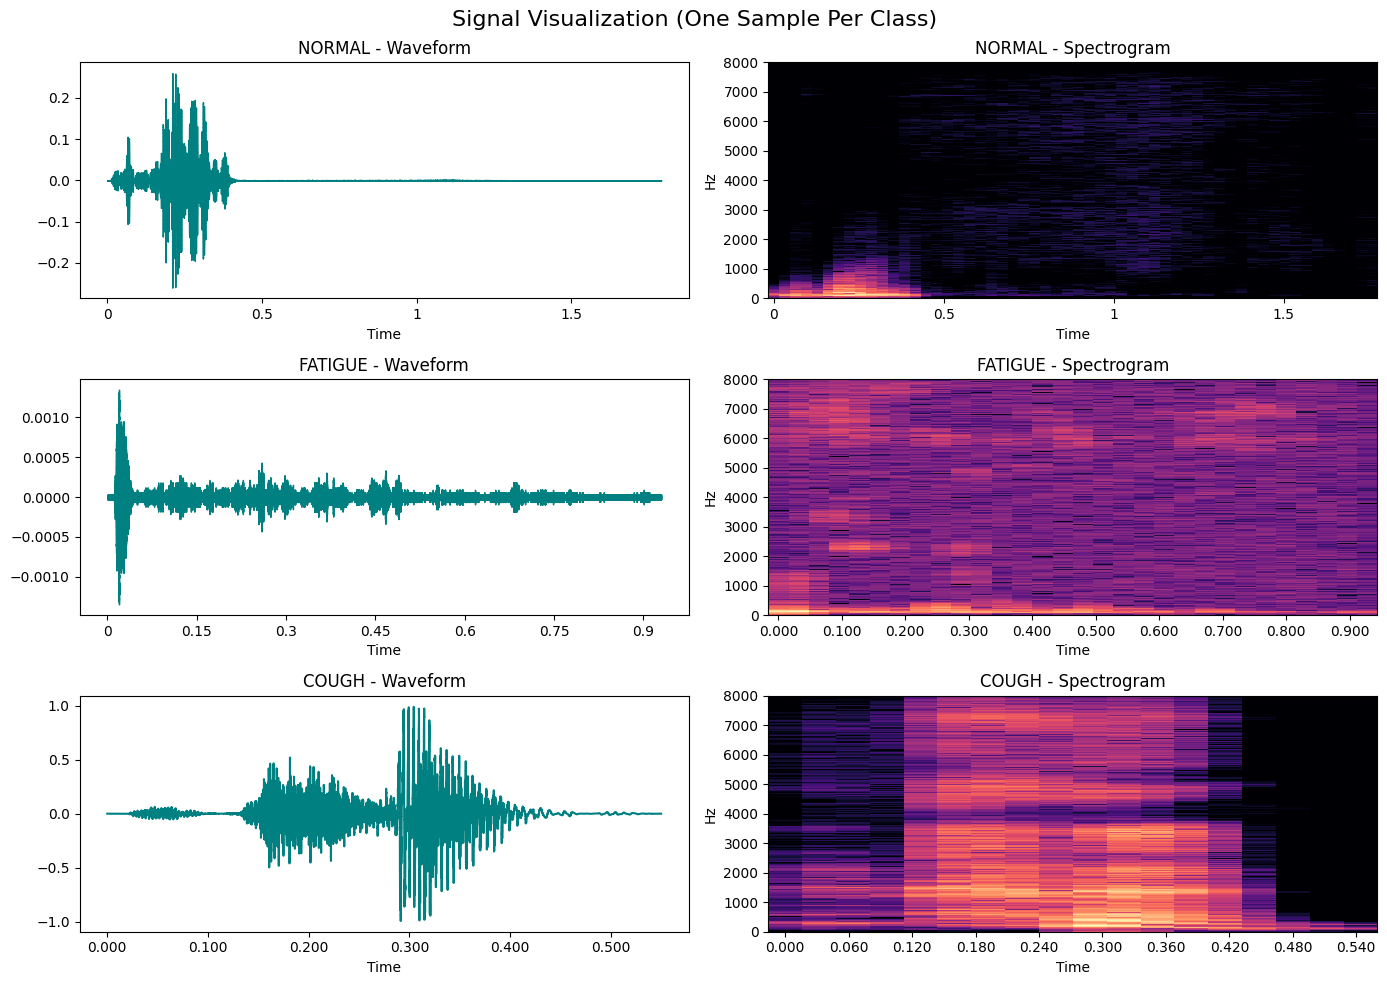

In [4]:
def plot_sample_spectrograms(audio_data, meta_df):
    classes = ['normal', 'fatigue', 'cough']
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle("Signal Visualization (One Sample Per Class)", fontsize=16)
    
    for i, label in enumerate(classes):
        # Find first sample for this class
        subset = meta_df[meta_df['label'] == label]
        if subset.empty: continue
        
        idx = subset.index[0]
        y = audio_data[idx]
        
        # Waveform
        librosa.display.waveshow(y, sr=SR, ax=axes[i, 0], color='teal')
        axes[i, 0].set_title(f"{label.upper()} - Waveform")
        
        # Spectrogram
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        img = librosa.display.specshow(D, sr=SR, x_axis='time', y_axis='hz', ax=axes[i, 1], cmap='magma')
        axes[i, 1].set_title(f"{label.upper()} - Spectrogram")
        axes[i, 1].set_ylim(0, 8000)
        
    plt.tight_layout()
    plt.show()

plot_sample_spectrograms(X_raw_audio, df_meta)

# Feature Extraction

In [5]:
# --- HELPER FUNCTIONS ---
def get_spectral_ratios(y, sr):
    if len(y) == 0: return 0, 0, 0
    S = np.abs(librosa.stft(y))
    freqs = librosa.fft_frequencies(sr=sr)
    total = np.sum(S) + 1e-9
    
    # Mid: 400-1000 Hz, High: 2000+ Hz
    e_mid = np.sum(S[(freqs >= 400) & (freqs < 1000)])
    e_high = np.sum(S[freqs >= 2000])
    
    # Entropy
    psd_norm = np.mean(S, axis=1) / (np.sum(np.mean(S, axis=1)) + 1e-9)
    ent = entropy(psd_norm)
    return e_mid/total, e_high/total, ent

def hjorth_mobility(y):
    if len(y) < 2: return 0
    var_y = np.var(y)
    if var_y == 0: return 0
    return np.sqrt(np.var(np.diff(y)) / var_y)

# --- MAIN EXTRACTOR ---
def extract_targeted_features(meta_df, annot_dir, sr=16000):
    feature_rows = []
    print("Extracting targeted features...")
    
    # Re-process file-by-file for BPM context
    unique_files = meta_df['file_source'].unique()
    
    for fname in unique_files:
        csv_path = os.path.join(annot_dir, fname + ".csv")
        if not os.path.exists(csv_path): continue
        
        # Read & Sort for Temporal Context
        df_csv = pd.read_csv(csv_path, header=None, names=['start', 'end', 'label'])
        df_csv = df_csv.sort_values('start')
        
        prev_starts = df_csv['start'].shift(1)
        ibis = (df_csv['start'] - prev_starts).fillna(3.0).clip(0.5, 10.0)
        bpms = 60 / (ibis + 1e-6)
        
        # Match audio segments
        file_indices = meta_df[meta_df['file_source'] == fname].index
        
        for i, idx in enumerate(file_indices):
            if i >= len(df_csv): break
            
            y = X_raw_audio[idx]
            if len(y) == 0: y = np.zeros(100)
            
            # --- CALCULATE ONLY NEEDED FEATURES ---
            # 1. Physics
            duration = len(y) / sr
            rms = np.sqrt(np.mean(y**2))
            
            # 2. Spectral & Complexity
            r_mid, r_high, ent = get_spectral_ratios(y, sr)
            mob = hjorth_mobility(y)
            
            # 3. Temporal
            bpm = bpms.iloc[i]
            ibi = ibis.iloc[i]
            duty = duration / (ibi + 1e-6)
            
            # 4. MFCCs (Specific Indices Only)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            if mfcc.shape[1] > 0:
                m_means = np.mean(mfcc, axis=1)
                m_stds = np.std(mfcc, axis=1)
            else:
                m_means, m_stds = np.zeros(13), np.zeros(13)
            
            row = {
                # Direct Physics
                'duration': duration, 'rms': rms,
                'ratio_mid': r_mid, 'ratio_high': r_high,
                'mobility': mob, 'entropy': ent,
                'bpm': bpm, 'duty_cycle': duty, 'ibi': ibi,
                
                # Selected MFCC Means
                'mfcc_0_mean': m_means[0], 'mfcc_1_mean': m_means[1],
                'mfcc_2_mean': m_means[2], 'mfcc_3_mean': m_means[3],
                'mfcc_4_mean': m_means[4], 'mfcc_6_mean': m_means[6],
                'mfcc_7_mean': m_means[7], 'mfcc_11_mean': m_means[11],
                'mfcc_12_mean': m_means[12],
                
                # Selected MFCC Stds
                'mfcc_2_std': m_stds[2], 'mfcc_5_std': m_stds[5]
            }
            feature_rows.append(row)
            
    return pd.DataFrame(feature_rows)

# Execute
df_features = extract_targeted_features(df_meta, ANNOT_DIR, SR)
df_features['label'] = df_meta['label'].values
df_features['subject_id'] = df_meta['subject_id'].values

print(f"Feature Matrix Shape: {df_features.shape}")

Extracting targeted features...
Feature Matrix Shape: (422, 22)


# Model Setup and Training

--- TRAINING EXTRA TREES (LOSO Validation) ---
Samples: 422

Final Accuracy: 81.52%
              precision    recall  f1-score   support

       cough       0.97      0.93      0.95       100
     fatigue       0.79      0.82      0.80       193
      normal       0.74      0.72      0.73       129

    accuracy                           0.82       422
   macro avg       0.83      0.82      0.83       422
weighted avg       0.82      0.82      0.82       422



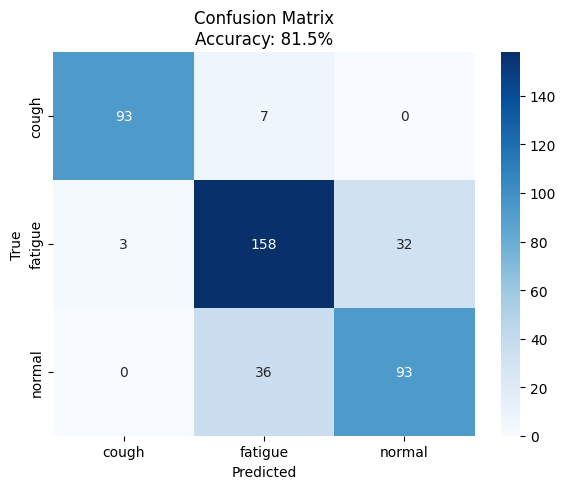

In [18]:
# --- MODEL SETUP ---
X = df_features.drop(['label', 'subject_id'], axis=1).values
y_raw = df_features['label']
groups = df_features['subject_id']

# Encode
le = LabelEncoder()
y = le.fit_transform(y_raw)
class_names = [str(c) for c in le.classes_]

# Classifier
clf = ExtraTreesClassifier(n_estimators=200, class_weight='balanced', random_state=42, bootstrap=False)
logo = LeaveOneGroupOut()

print(f"--- TRAINING EXTRA TREES (LOSO Validation) ---")
print(f"Samples: {len(X)}")

y_true_all = []
y_pred_all = []
y_prob_all = []

# --- TRAINING LOOP ---
for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)
    
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)
    y_prob_all.extend(y_prob)

# --- RESULTS ---
acc = accuracy_score(y_true_all, y_pred_all) * 100
print(f"\nFinal Accuracy: {acc:.2f}%")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

# --- PLOT ---
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_true_all, y_pred_all)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix\nAccuracy: {acc:.1f}%")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Hypothesis Testing Report

       FINAL SCIENTIFIC HYPOTHESIS TESTING REPORT       
--- [H1] PHYSIOLOGICAL CHANGES (Fatigue vs Normal) ---
Why: To prove fatigue causes measurable changes in rate and effort.
  > BPM: p=6.94e-30 (SIGNIFICANT)
    Mean: Normal=18.71 vs Fatigue=25.50
  > RMS: p=1.11e-03 (SIGNIFICANT)
    Mean: Normal=0.00 vs Fatigue=0.01

--- [H2] EVENT DISTINCTNESS (Cough vs Breathing) ---
Why: To prove coughs are spectrally distinct events, allowing detection.
  > ENTROPY: p=3.75e-13 (SIGNIFICANT)
    Mean: Cough=6.04 vs Breath=6.54
  > RATIO_HIGH: p=7.00e-33 (SIGNIFICANT)
    Mean: Cough=0.36 vs Breath=0.68

--- [H3] SYSTEM PERFORMANCE (Classification Accuracy) ---
Why: To prove the algorithm can reliably distinguish all 3 states.
  > Overall Accuracy: 81.52%
    RESULT: HYPOTHESIS CONFIRMED

  > Per-Class Reliability:
    - COUGH: Precision=0.97 | Recall=0.93 | F1=0.95
    - FATIGUE: Precision=0.79 | Recall=0.82 | F1=0.80
    - NORMAL: Precision=0.74 | Recall=0.72 | F1=0.73


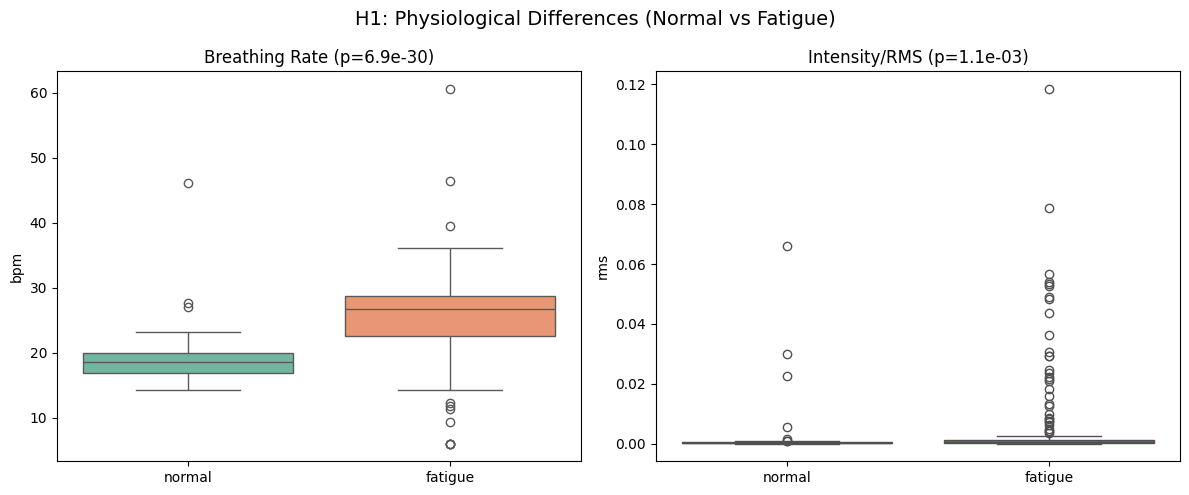

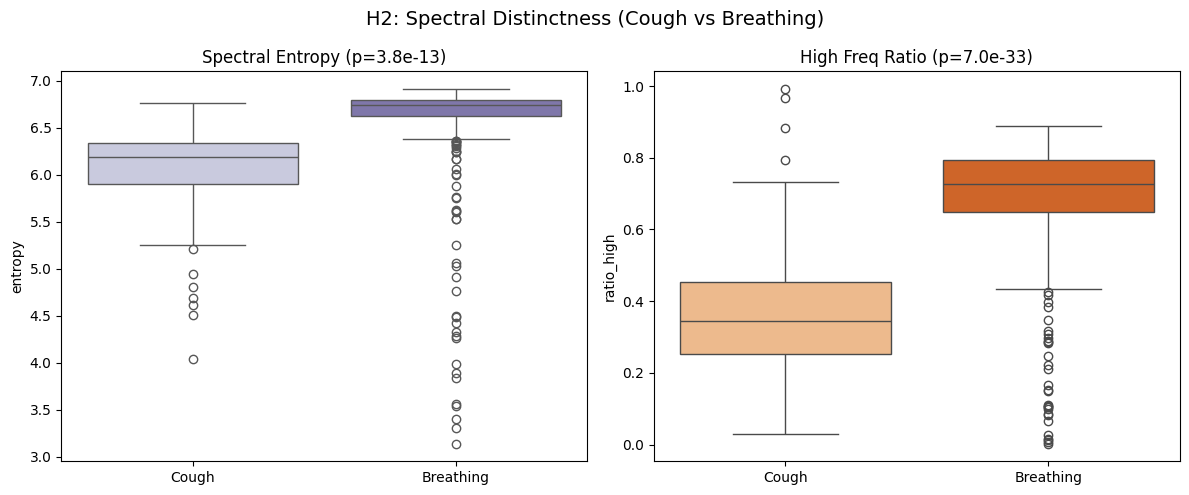

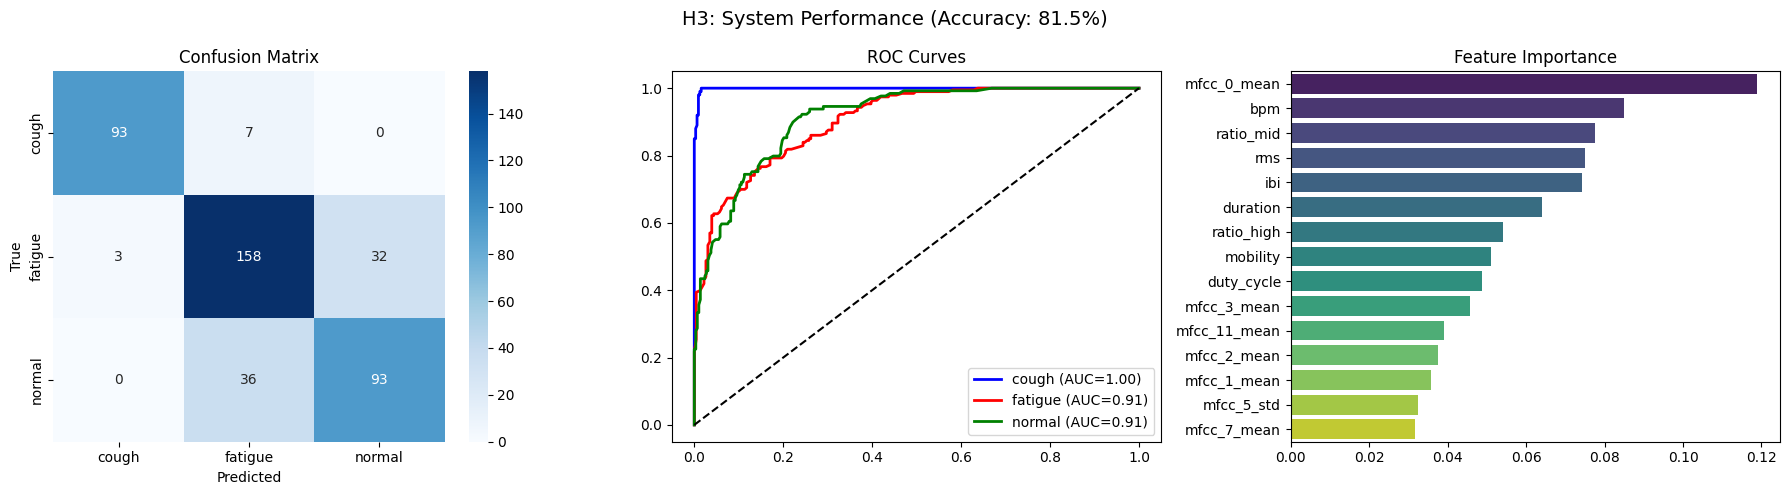

In [ ]:
def perform_final_scientific_validation(df, clf, X, y, y_true, y_pred, y_prob):
    # --- 1. SETUP & CALCULATIONS ---
    # Group Data for T-Tests
    group_norm = df[df['label'] == 'normal']
    group_fatg = df[df['label'] == 'fatigue']
    group_cough = df[df['label'] == 'cough']
    group_breath = df[df['label'].isin(['normal', 'fatigue'])]

    # H1 Stats
    t_bpm, p_bpm = stats.ttest_ind(group_norm['bpm'], group_fatg['bpm'], equal_var=False)
    t_rms, p_rms = stats.ttest_ind(group_norm['rms'], group_fatg['rms'], equal_var=False)

    # H2 Stats
    t_ent, p_ent = stats.ttest_ind(group_cough['entropy'], group_breath['entropy'], equal_var=False)
    t_rhi, p_rhi = stats.ttest_ind(group_cough['ratio_high'], group_breath['ratio_high'], equal_var=False)

    # H3 Stats
    acc = accuracy_score(y_true, y_pred) * 100
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    # --- 2. TEXT REPORT ---
    print("========================================================")
    print("       FINAL SCIENTIFIC HYPOTHESIS TESTING REPORT       ")
    print("========================================================")
    
    print("--- [H1] PHYSIOLOGICAL CHANGES (Fatigue vs Normal) ---")
    print("Why: To prove fatigue causes measurable changes in rate and effort.")
    print(f"  > BPM: p={p_bpm:.2e} ({'SIGNIFICANT' if p_bpm<0.05 else 'NOT SIG'})")
    print(f"    Mean: Normal={group_norm['bpm'].mean():.2f} vs Fatigue={group_fatg['bpm'].mean():.2f}")
    print(f"  > RMS: p={p_rms:.2e} ({'SIGNIFICANT' if p_rms<0.05 else 'NOT SIG'})")
    print(f"    Mean: Normal={group_norm['rms'].mean():.2f} vs Fatigue={group_fatg['rms'].mean():.2f}")

    print("\n--- [H2] EVENT DISTINCTNESS (Cough vs Breathing) ---")
    print("Why: To prove coughs are spectrally distinct events, allowing detection.")
    print(f"  > ENTROPY: p={p_ent:.2e} ({'SIGNIFICANT' if p_ent<0.05 else 'NOT SIG'})")
    print(f"    Mean: Cough={group_cough['entropy'].mean():.2f} vs Breath={group_breath['entropy'].mean():.2f}")
    print(f"  > RATIO_HIGH: p={p_rhi:.2e} ({'SIGNIFICANT' if p_rhi<0.05 else 'NOT SIG'})")
    print(f"    Mean: Cough={group_cough['ratio_high'].mean():.2f} vs Breath={group_breath['ratio_high'].mean():.2f}")

    print("\n--- [H3] SYSTEM PERFORMANCE (Classification Accuracy) ---")
    print("Why: To prove the algorithm can reliably distinguish all 3 states.")
    print(f"  > Overall Accuracy: {acc:.2f}%")
    print(f"    RESULT: {'HYPOTHESIS CONFIRMED' if acc > 75 else 'HYPOTHESIS FAILED'}")
    
    print("\n  > Per-Class Reliability:")
    for cls in class_names:
        prec = report[cls]['precision']
        rec = report[cls]['recall']
        f1 = report[cls]['f1-score']
        print(f"    - {cls.upper()}: Precision={prec:.2f} | Recall={rec:.2f} | F1={f1:.2f}")

    # --- 3. PLOT FIGURE 1: H1 (Physiology) ---
    fig1, ax1 = plt.subplots(1, 2, figsize=(12, 5))
    fig1.suptitle("H1: Physiological Differences (Normal vs Fatigue)", fontsize=14)
    
    sns.boxplot(data=df, x='label', y='bpm', order=['normal', 'fatigue'], palette='Set2', ax=ax1[0])
    ax1[0].set_title(f"Breathing Rate (p={p_bpm:.1e})")
    ax1[0].set_xlabel("")
    
    sns.boxplot(data=df, x='label', y='rms', order=['normal', 'fatigue'], palette='Reds', ax=ax1[1])
    ax1[1].set_title(f"Intensity/RMS (p={p_rms:.1e})")
    ax1[1].set_xlabel("")
    plt.tight_layout()
    plt.show()

    # --- 4. PLOT FIGURE 2: H2 (Spectral) ---
    fig2, ax2 = plt.subplots(1, 2, figsize=(12, 5))
    fig2.suptitle("H2: Spectral Distinctness (Cough vs Breathing)", fontsize=14)
    
    df_plot = df.copy()
    df_plot['type'] = df_plot['label'].apply(lambda x: 'Cough' if x=='cough' else 'Breathing')
    
    sns.boxplot(data=df_plot, x='type', y='entropy', palette='Purples', ax=ax2[0])
    ax2[0].set_title(f"Spectral Entropy (p={p_ent:.1e})")
    ax2[0].set_xlabel("")
    
    sns.boxplot(data=df_plot, x='type', y='ratio_high', palette='Oranges', ax=ax2[1])
    ax2[1].set_title(f"High Freq Ratio (p={p_rhi:.1e})")
    ax2[1].set_xlabel("")
    plt.tight_layout()
    plt.show()

    # --- 5. PLOT FIGURE 3: H3 (Performance) ---
    fig3, ax3 = plt.subplots(1, 3, figsize=(18, 5))
    fig3.suptitle(f"H3: System Performance (Accuracy: {acc:.1f}%)", fontsize=14)
    
    # A. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax3[0])
    ax3[0].set_title("Confusion Matrix")
    ax3[0].set_ylabel('True'); ax3[0].set_xlabel('Predicted')
    
    # B. ROC Curves
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    y_prob_arr = np.array(y_prob)
    colors = ['blue', 'red', 'green']
    for i, color, name in zip(range(len(class_names)), colors, class_names):
        if i < y_prob_arr.shape[1]:
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob_arr[:, i])
            roc_auc = auc(fpr, tpr)
            ax3[1].plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC={roc_auc:.2f})')
    ax3[1].plot([0, 1], [0, 1], 'k--')
    ax3[1].legend(loc='lower right')
    ax3[1].set_title("ROC Curves")
    
    # C. Feature Importance
    # We retrain CLF on full data to get global importance
    clf.fit(X, y)
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1][:15]
    feature_names = df.drop(['label', 'subject_id'], axis=1).columns
    sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices], palette='viridis', ax=ax3[2])
    ax3[2].set_title("Feature Importance")
    
    plt.tight_layout()
    plt.show()

# EXECUTE
# Ensure these variables exist from previous cell: df_features, clf, X, y, y_true_all, y_pred_all, y_prob_all
perform_final_scientific_validation(df_features, clf, X, y, y_true_all, y_pred_all, y_prob_all)